# introduction
This notebook analyses data, generated by the [plastic scanner project](https://plasticscanner.com).

More specifically, the third dataset, taken using the avantes spectrometer is used. It can be found:\
https://github.com/Plastic-Scanner/data/tree/main/data/20230302_avantes_spectrometer_third_dataset/

The spectra, measured in that dataset are then combined with the spectral emission's and sensitivity's for the LED's and IR sensor, used in the plastic scanner.

This combination simulates the expected outputs of the plastic scanner, given ideal sircumstances.

Author: [Joost Scheffer](https://github.com/JoostScheffer) @ 2023-03-17

In [1]:
import glob
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
!ls data/data/20230302_avantes_spectrometer_third_dataset/

A01C_PET_FDP.csv   C01C_PVC_FDP.csv   E01C_PP_FDP.csv
A02C_PET_FDP.csv   C02C_PVC_FDP.csv   E02C_PP_FDP.csv
A03C_PET_FDP.csv   C03C_PVC_FDP.csv   E03C_PP_FDP.csv
A04C_PET_FDP.csv   C04C_PVC_FDP.csv   E04C_PP_FDP.csv
A05C_PET_FDP.csv   C05C_PVC_FDP.csv   E05C_PP_FDP.csv
B01C_HDPE_FDP.csv  C06C_PVC_FDP.csv   F01C_PS_FDP.csv
B02C_HDPE_FDP.csv  D01C_LDPE_FDP.csv  F02C_PS_FDP.csv
B03C_HDPE_FDP.csv  D02C_LDPE_FDP.csv  F03C_PS_FDP.csv
B04C_HDPE_FDP.csv  D03C_LDPE_FDP.csv  F04C_PS_FDP.csv
B05C_HDPE_FDP.csv  D04C_LDPE_FDP.csv  RefSpectrum_PlSc_FDP.csv


# load spectra into single dataframe
1. load data from files
2. apply snv transform on each unique spectrum
3. apply baseline subtraction on each unique spectrum
4. merge the 5 spectrums from each sample into 1 spectrum by using the mean


5. create dataframe for the mean spectrum for each id
6. create dict, key: type, value: list of id's with that type

In [101]:
p = Path("data/data/20230302_avantes_spectrometer_third_dataset/")
files = list(p.glob("[!RefSpectrum]*.csv"))

In [58]:
_pre_df_dict = {}
type_id = {}
for file in files:
    samp_id, samp_type, _ = file.stem.split("_")
    if samp_type not in type_id:
        type_id[samp_type] = []
    type_id[samp_type].append(samp_id)

    wavelengths = np.loadtxt(file, skiprows=6, delimiter=",", usecols=[0])
    spectra = np.loadtxt(file, skiprows=6, delimiter=",", usecols=[1, 2, 3, 4, 5]).T
    # apply snv
    spectra_snv = (spectra.T - np.mean(spectra, axis=1)) / np.std(spectra, axis=1)
    # subtract baseline
    spectra_baseline_normal = np.apply_along_axis(
        lambda x: x.T - np.polyval(np.polyfit(wavelengths, x, deg=2), wavelengths),
        0,
        spectra_snv,
    ).T
    # std_snv = np.std(spectra_snv, axis=1)
    # std_norm = np.std(spectra_baseline_normal, axis=0)
    # mean
    mean = np.mean(spectra_baseline_normal, axis=0)
    _pre_df_dict[samp_id] = mean

In [60]:
# df for spectra
df = pd.DataFrame.from_dict(_pre_df_dict, orient="index", columns=wavelengths)
df.head()

,1014.478516,1019.012782,1023.542490,1028.067635,1032.588212,1037.104217,1041.615645,1046.122493,1050.624755,1055.122428,...,1870.414962,1873.879635,1877.338819,1880.792510,1884.240704,1887.683397,1891.120583,1894.552259,1897.978420,1901.399062
E03C,-1.468605,-1.337238,-1.213622,-1.128412,-1.027641,-0.884051,-0.775837,-0.628121,-0.593976,-0.503802,...,0.309471,0.303404,0.347131,0.346339,0.364017,0.336801,0.340708,0.366145,0.406200,0.396793
B03C,-1.423158,-1.299468,-1.185463,-1.115145,-1.029836,-0.901554,-0.802173,-0.657229,-0.626820,-0.539413,...,0.358420,0.357518,0.407250,0.407542,0.430345,0.405376,0.415020,0.444534,0.487561,0.479198
E01C,-1.482548,-1.354857,-1.237264,-1.158405,-1.064831,-0.929430,-0.827092,-0.686201,-0.655634,-0.571349,...,0.326120,0.321660,0.367687,0.367693,0.386958,0.364001,0.370051,0.395402,0.434760,0.426798
C01C,-1.534220,-1.423781,-1.314875,-1.237333,-1.145998,-1.017960,-0.921966,-0.800063,-0.755523,-0.672622,...,0.351344,0.357212,0.394304,0.401199,0.425349,0.414332,0.426597,0.450516,0.480238,0.480990
D02C,-1.560956,-1.444029,-1.332990,-1.257407,-1.167544,-1.037941,-0.941291,-0.814343,-0.776700,-0.695047,...,0.309758,0.312930,0.354479,0.357966,0.381988,0.365115,0.376580,0.403296,0.437064,0.434866


# plot the spectra of all of the plastic types

In [84]:
ticks = [1050, 1200, 1300, 1450, 1550, 1650, 1720]

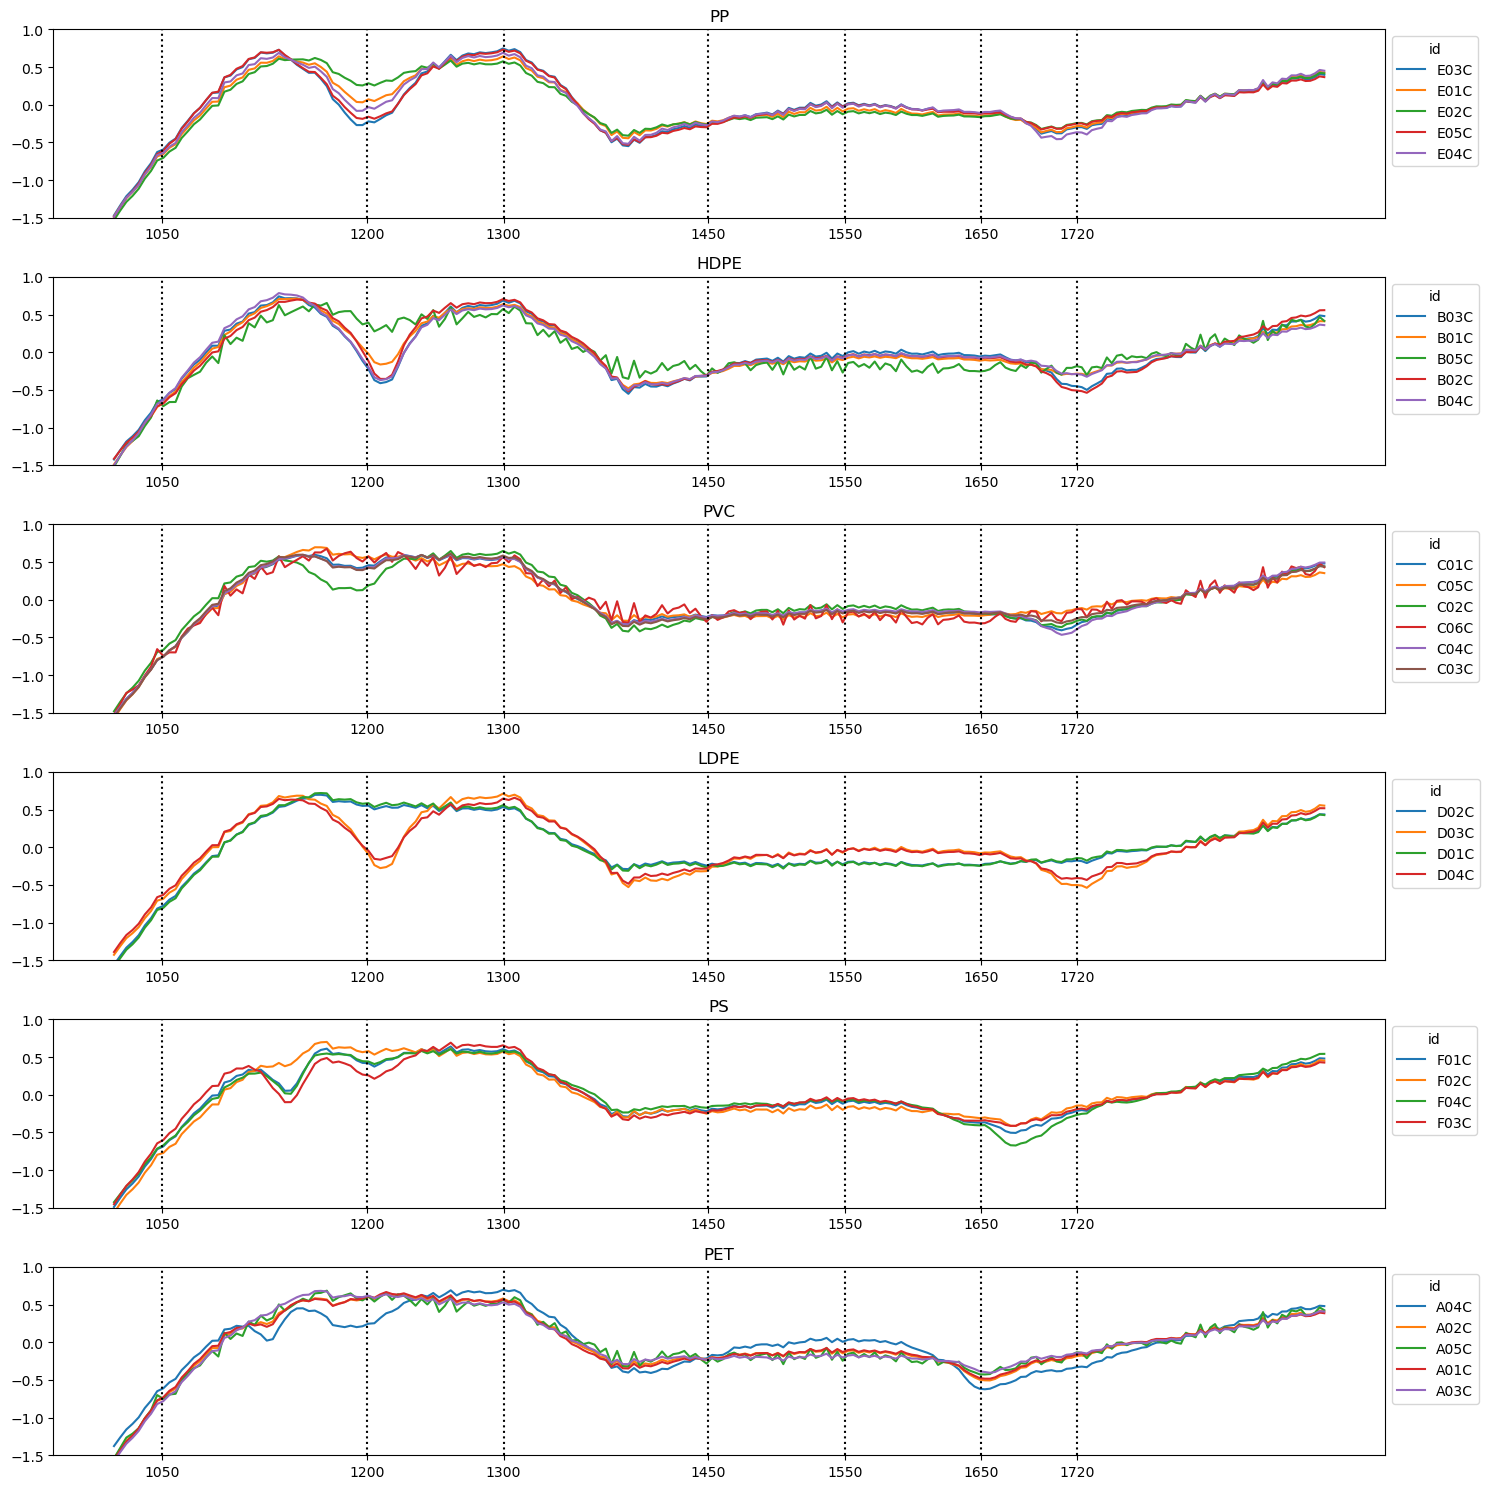

In [188]:
fig, axs = plt.subplots(len(type_id), 1, figsize=[15, 15])

for typ, ax in zip(type_id, axs):
    for sid in type_id[typ]:
        ax.plot(df.loc[sid], label=sid)
    ax.set_title(typ)
    ax.legend(title="id", bbox_to_anchor=(1, 1))

    for x in ticks:
        ax.axvline(x=x, ymin=0, ymax=1, color="k", linestyle="dotted")
    ax.set_xticks(ticks, list(map(str, ticks)))
    ax.set_ylim(-1.5, 1)

plt.tight_layout()

# simulate LED exposure and measurement

## load all arrays taken from datasheets

In [149]:
!ls LED_spectra

1050.npy  1300.npy  1550.npy  1720.npy	sensor.npy
1200.npy  1460.npy  1650.npy  940.npy


In [163]:
p = Path("LED_spectra/")
files = list(p.glob("[!sensor, 940]*.npy"))
(sensor,) = list(p.glob("sensor.npy"))

wavelengths_led = np.linspace(700, 1900, 1100)

Here linear interpolation is used because the sampling that was used for digitizing the datasheets is diferent from the samping that the avantes spectrometer uses.

In [164]:
sensor_spectrum = np.load(sensor)
sensor_spectrum = np.interp(wavelengths, wavelengths_led, sensor_spectrum)

In [165]:
led_spectra = []
for file in files:
    led_spectrum = np.load(file)
    led_spectrum = np.interp(wavelengths, wavelengths_led, led_spectrum)
    led_spectra.append(led_spectrum)

## plot the spectra of the LEDs

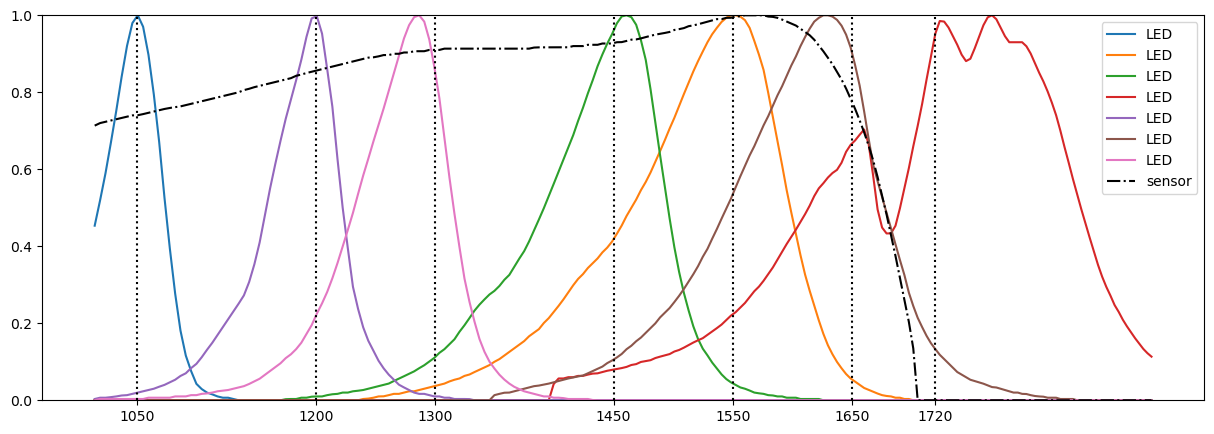

In [206]:
plt.figure(figsize=[15, 5])
for idx, led in enumerate(led_spectra):
    plt.plot(wavelengths, led, label="LED")

plt.plot(wavelengths, sensor_spectrum, linestyle="-.", color="k", label="sensor")

for x in ticks:
    plt.axvline(x=x, ymin=0, ymax=1, color="k", linestyle="dotted")
plt.xticks(ticks, list(map(str, ticks)))
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1, 1))

plt.show()

## plot the spectra of all plastic types, together with the spectra of the LEDs

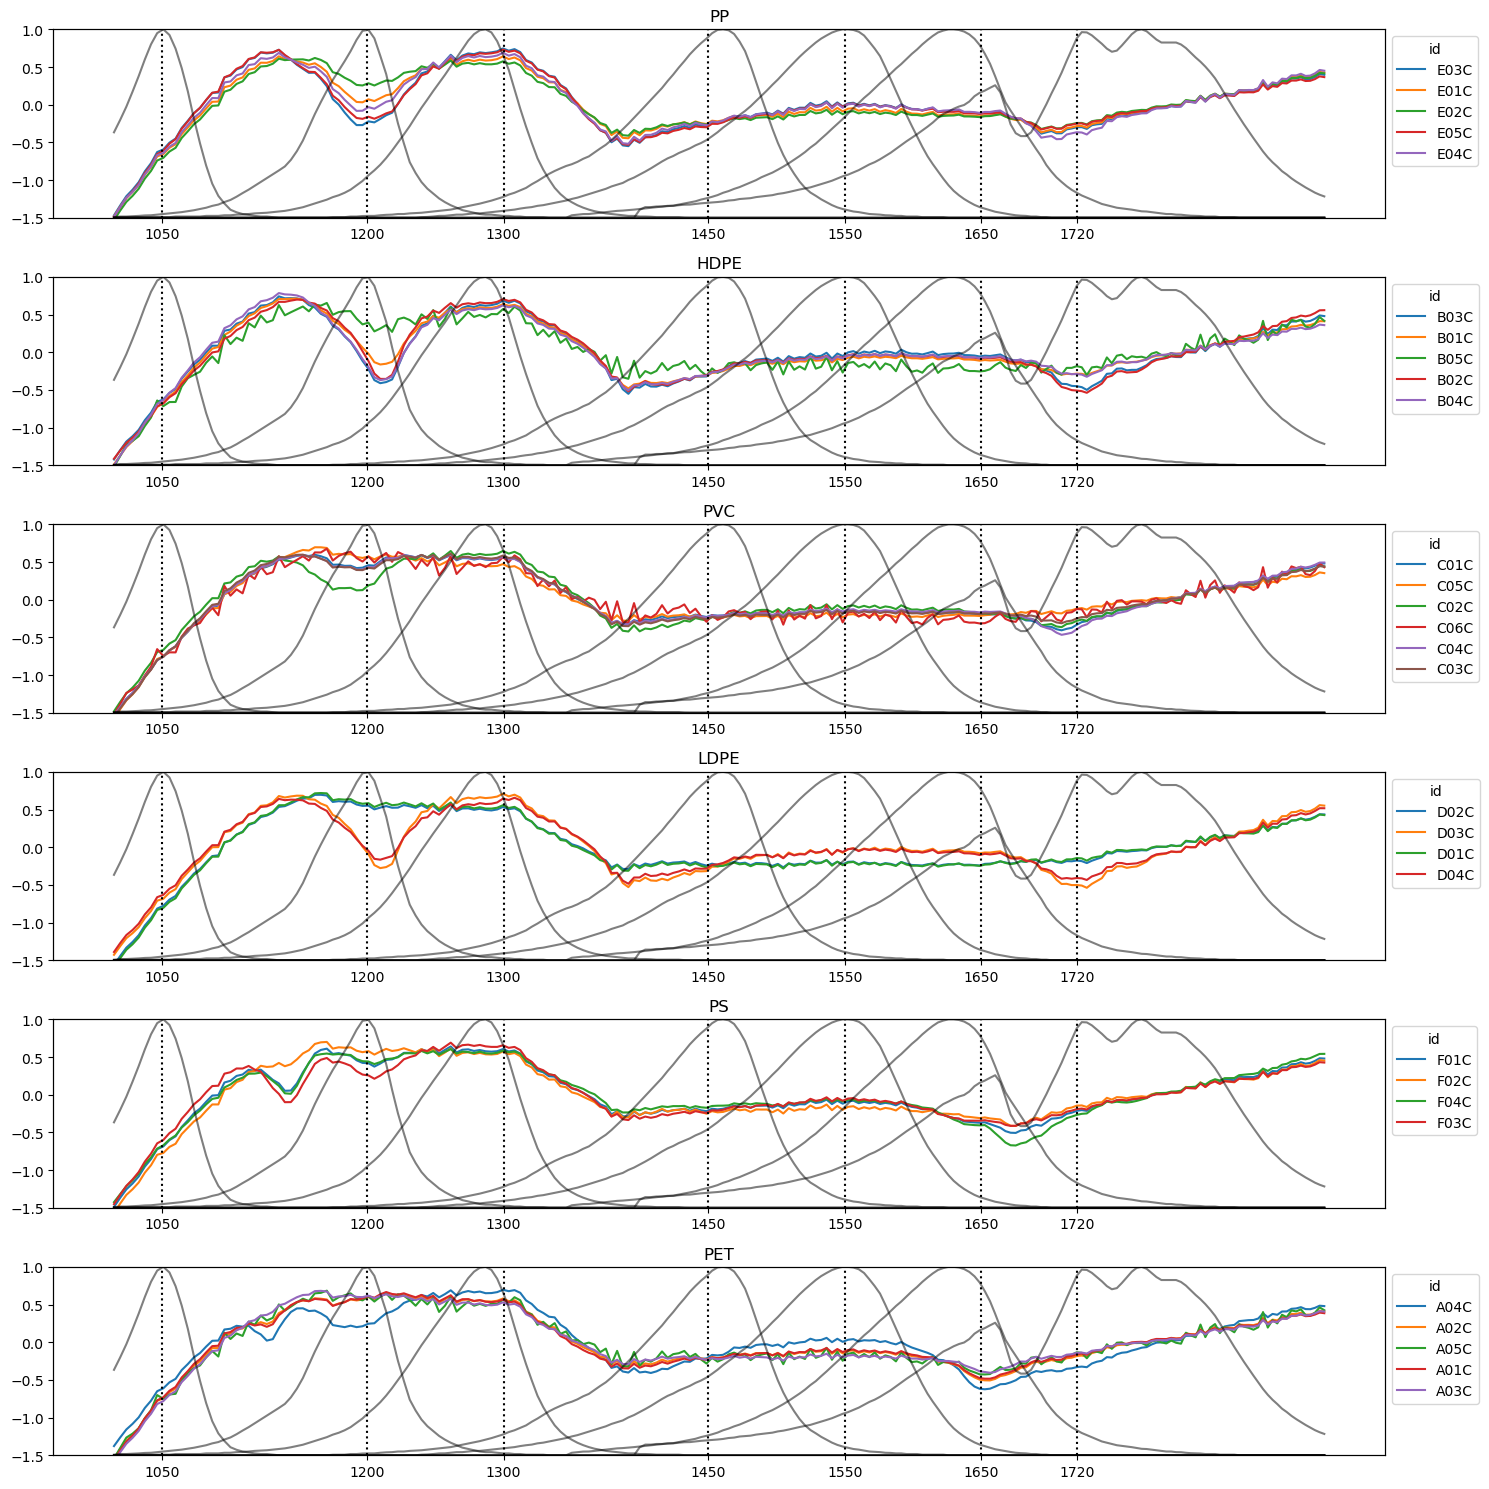

In [195]:
fig, axs = plt.subplots(len(type_id), 1, figsize=[15, 15])

for typ, ax in zip(type_id, axs):
    for sid in type_id[typ]:
        ax.plot(df.loc[sid], label=sid)
    ax.set_title(typ)
    ax.legend(title="id", bbox_to_anchor=(1, 1))

    for x in ticks:
        ax.axvline(x=x, ymin=0, ymax=1, color="k", linestyle="dotted")
    ax.set_xticks(ticks, list(map(str, ticks)))
    ax.set_ylim(-1.5, 1)

    ax2 = ax.twinx()
    for idx, led in enumerate(led_spectra):
        ax2.plot(wavelengths, led, "k", alpha=0.5)
    ax2.set_yticks([])
    ax2.set_ylim(0, 1)

plt.tight_layout()

## simulate taking a measurement using the plastic scanner
pseudo code:
```txt
for each spectrum:
    for each led:
        multiply the spectrum by the spectrum of the LED and the spectrum of the sensor
        take the sum of this product and add it to a list
    
    apply snv and baseline subtraction to this list
    
    plot
```

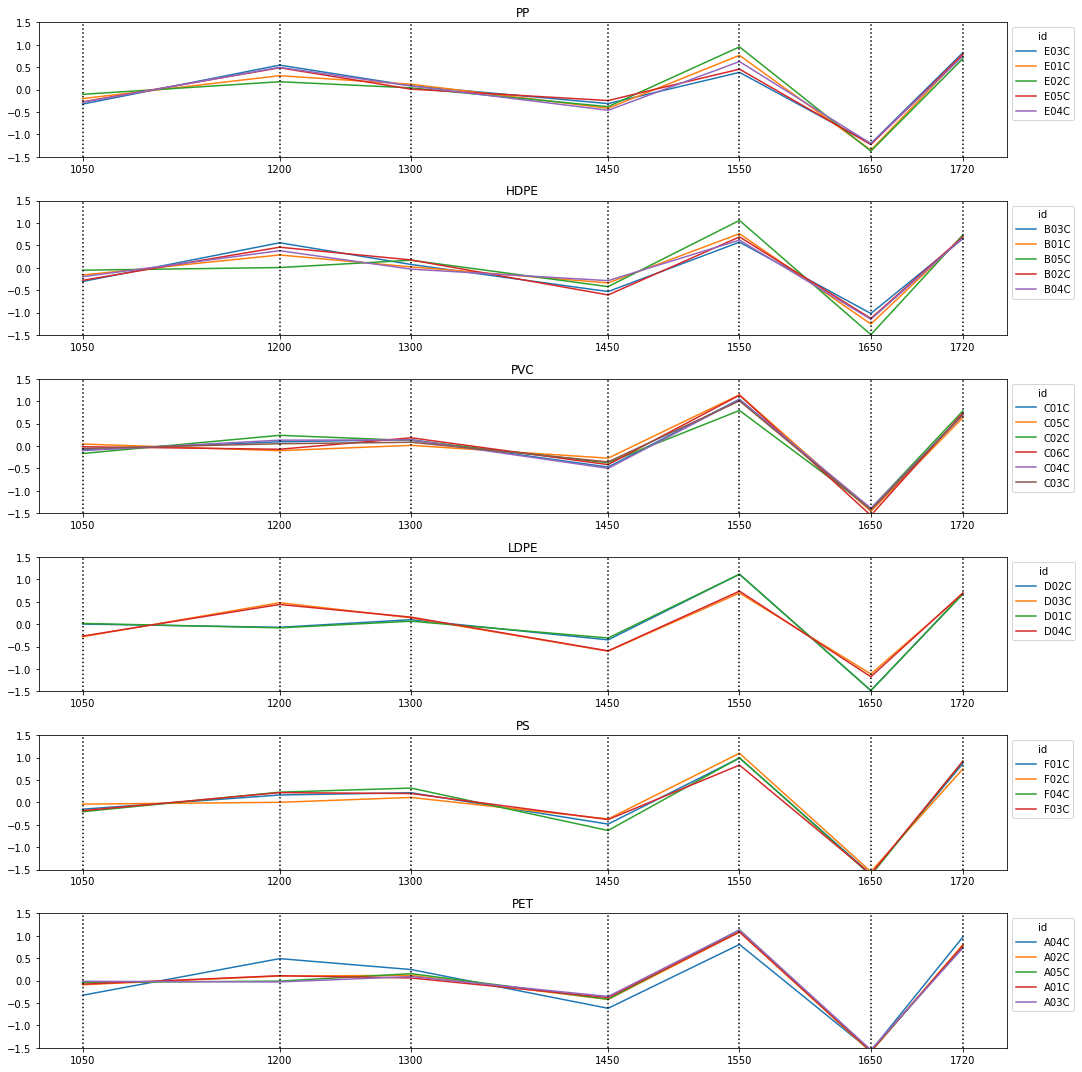

In [168]:
fig, axs = plt.subplots(len(type_id), 1, figsize=[15, 15])

typ_symulated_baseline_normal = {typ:[] for typ in type_id}

for typ, ax in zip(type_id, axs):
    for sid in type_id[typ]:
        spectrum = df.loc[sid].values
        points = []
        for led in led_spectra:
            # multiply
            product = led * spectrum
            # integrate
            points.append(sum(product))
        # apply snv and normalisation
        points = np.array(points)
        points_snv = (points - points.mean()) / points.std()
        points_baseline_normal = points_snv - np.polyval(
            np.polyfit(ticks, points_snv, deg=2), ticks
        )
        typ_symulated_baseline_normal[typ].append(points_baseline_normal)
        # plot
        ax.plot(ticks, points_baseline_normal, label=sid)

    ax.set_title(typ)
    ax.legend(title="id", bbox_to_anchor=(1, 1))

    for x in ticks:
        ax.axvline(x=x, ymin=0, ymax=1, color="k", linestyle="dotted")
    ax.set_xticks(ticks, list(map(str, ticks)))
    ax.set_ylim(-1.5, 1.5)

plt.tight_layout()

### plot all simulations together

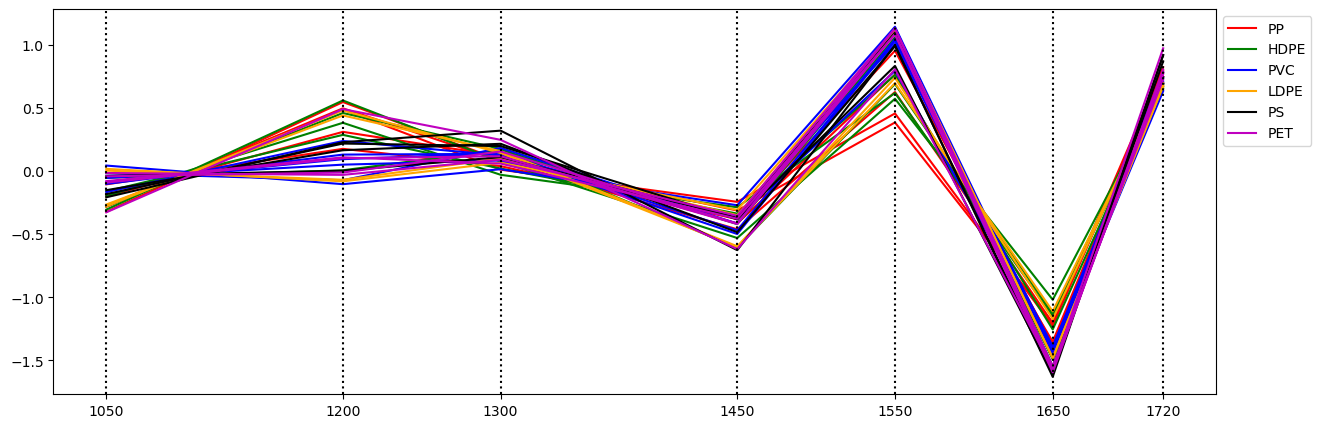

In [207]:
plt.figure(figsize=[15, 5])

for typ, color in zip(type_id, ["r", "g", "b", "orange", "k", "m", "teal"]):
    for idx, spec in enumerate(typ_symulated_baseline_normal[typ]):
        if idx == 0:
            plt.plot(ticks, spec, c=color, label=typ)
        else:
            plt.plot(ticks, spec, c=color)

for x in ticks:
    plt.axvline(x=x, ymin=0, ymax=1, color="k", linestyle="dotted")
plt.xticks(ticks, list(map(str, ticks)))

plt.legend(bbox_to_anchor=(1, 1))
plt.show()